## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 l1
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/l1 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===

Epoch 47/50
50000/50000 [==============================] - 20s 406us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 20s 396us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 19s 376us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 17s 334us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________

50000/50000 [==============================] - 21s 429us/step - loss: 2.8622 - accuracy: 0.6217 - val_loss: 3.1316 - val_accuracy: 0.5281
Epoch 45/50
50000/50000 [==============================] - 22s 443us/step - loss: 2.8278 - accuracy: 0.6199 - val_loss: 3.0636 - val_accuracy: 0.5343
Epoch 46/50
50000/50000 [==============================] - 21s 413us/step - loss: 2.7882 - accuracy: 0.6208 - val_loss: 3.1268 - val_accuracy: 0.5007
Epoch 47/50
50000/50000 [==============================] - 20s 400us/step - loss: 2.7502 - accuracy: 0.6248 - val_loss: 2.9802 - val_accuracy: 0.5360
Epoch 48/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.7100 - accuracy: 0.6249 - val_loss: 3.0301 - val_accuracy: 0.5181
Epoch 49/50
50000/50000 [==============================] - 19s 384us/step - loss: 2.6745 - accuracy: 0.6275 - val_loss: 2.9394 - val_accuracy: 0.5285
Epoch 50/50
50000/50000 [==============================] - 21s 411us/step - loss: 2.6355 - accuracy: 0.6286 - va

50000/50000 [==============================] - 19s 372us/step - loss: 0.9877 - accuracy: 0.6554 - val_loss: 1.3447 - val_accuracy: 0.5287
Epoch 42/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.9750 - accuracy: 0.6585 - val_loss: 1.3645 - val_accuracy: 0.5303
Epoch 43/50
50000/50000 [==============================] - 20s 390us/step - loss: 0.9637 - accuracy: 0.6620 - val_loss: 1.3851 - val_accuracy: 0.5283
Epoch 44/50
50000/50000 [==============================] - 21s 417us/step - loss: 0.9566 - accuracy: 0.6657 - val_loss: 1.4497 - val_accuracy: 0.5098
Epoch 45/50
50000/50000 [==============================] - 20s 402us/step - loss: 0.9408 - accuracy: 0.6710 - val_loss: 1.3738 - val_accuracy: 0.5284
Epoch 46/50
50000/50000 [==============================] - 18s 363us/step - loss: 0.9311 - accuracy: 0.6726 - val_loss: 1.4724 - val_accuracy: 0.5090
Epoch 47/50
50000/50000 [==============================] - 22s 449us/step - loss: 0.9172 - accuracy: 0.6798 - va

50000/50000 [==============================] - 18s 350us/step - loss: 1.0121 - accuracy: 0.6437 - val_loss: 1.3753 - val_accuracy: 0.5162
Epoch 39/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.0007 - accuracy: 0.6506 - val_loss: 1.3733 - val_accuracy: 0.5248
Epoch 40/50
50000/50000 [==============================] - 18s 368us/step - loss: 0.9886 - accuracy: 0.6555 - val_loss: 1.4188 - val_accuracy: 0.5165
Epoch 41/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.9764 - accuracy: 0.6590 - val_loss: 1.4016 - val_accuracy: 0.5163
Epoch 42/50
50000/50000 [==============================] - 21s 412us/step - loss: 0.9614 - accuracy: 0.6631 - val_loss: 1.3786 - val_accuracy: 0.5246
Epoch 43/50
50000/50000 [==============================] - 21s 418us/step - loss: 0.9509 - accuracy: 0.6676 - val_loss: 1.3882 - val_accuracy: 0.5241
Epoch 44/50
50000/50000 [==============================] - 21s 427us/step - loss: 0.9369 - accuracy: 0.6713 - va

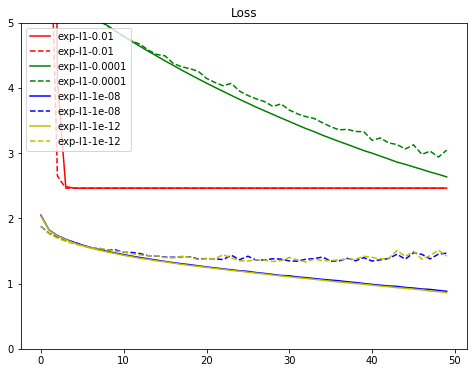

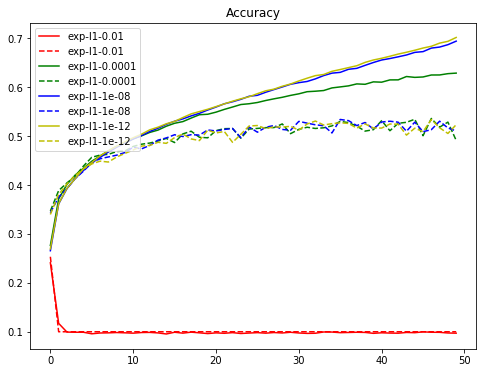

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()